In [1]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()
    
sys.path.append(os.path.join(root, '..', 'src'))
import fcLib
from fcSelector import ForecasterFramework, default_params

### load Camp Parks data

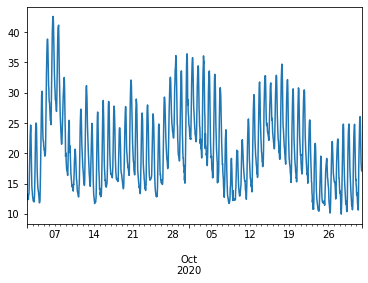

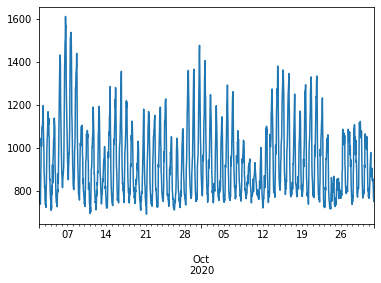

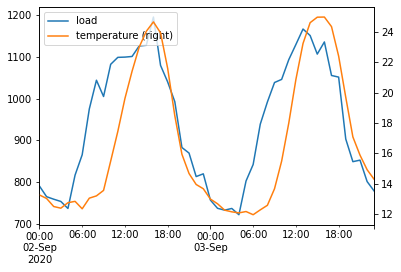

In [6]:
data = pd.read_csv(os.path.join('..', 'resources', 'Camp Parks Data', 'training data', 'Parks_2020_training_data_1hr.csv'), index_col=0)
data.index = pd.to_datetime(data['datetime'].values)#, unit='s', utc=True)
#data.index = data.index.tz_convert('US/Pacific').tz_localize(None) # Data is in UTC; convert to LOCAL time!
data = data[data.index.year==2020]
data = data.loc['2020-09-02':'2020-10-31']
data['hour'] = data.index.hour

data['temperature'].plot()
plt.show()

data['load'].plot()
plt.show()

data[['load', 'temperature']].iloc[:48].plot(secondary_y='temperature')
plt.show()

### What is best score?

In [3]:
fcList = fcLib.forecasters

fcList[0]['parameter']['temp_col'] = 'temperature'
fcList[10]['parameter']['oat_col'] = 'temperature'

data_eval = {
    'X': data[['temperature', 'hour']],
    'y': data['load']
}

params = default_params.copy()
params['train_method'] = 'daily_split'
params['train_size'] = 0.6
f = ForecasterFramework(params=params, data=data_eval, fcList=fcList)
f.evaluateAll(parallel=False)
f.fcData.sort_values('score_adj', ascending=False)

2022-06-08 22:42:46 INFO     evaluating model time of week temperature
2022-06-08 22:42:46 INFO     evaluating model extra trees pipeline
2022-06-08 22:42:46 INFO     evaluating model random forest pipeline
2022-06-08 22:42:46 INFO     evaluating model multi layer perceptron
2022-06-08 22:42:52 INFO     evaluating model tuned mlp
2022-06-08 22:43:03 INFO     evaluating model tuned-Total mlp
2022-06-08 22:43:15 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:43:23 INFO     evaluating model random forest
2022-06-08 22:43:24 INFO     evaluating model extra trees
2022-06-08 22:43:24 INFO     evaluating model sarimax
2022-06-08 22:43:25 INFO     evaluating model time of day temperature


,model,score,score_adj,score_mse,score_rmse,x-cols,y-cols,duration,msg,name
5,mlpregressor(),0.685806,0.676565,6849.435736,82.761318,"[""temperature"", ""hour""]","""load""",11.894154,,tuned-Total mlp
1,extratreespipeline(),0.683514,0.674205,6899.415039,83.062718,"[""temperature"", ""hour""]","""load""",0.115320,,extra trees pipeline
2,randomforestpipeline(),0.678701,0.669251,7004.334675,83.691903,"[""temperature"", ""hour""]","""load""",0.127876,,random forest pipeline
10,<fcLib.time_of_day_temperature object at 0x7fc...,0.676723,0.667214,7047.460596,83.949155,"[""temperature"", ""hour""]","""load""",0.133202,,time of day temperature
8,extratrees(),0.657012,0.646924,7477.160671,86.470577,"[""temperature"", ""hour""]","""load""",0.159524,,extra trees
6,mlpregressor(),0.647898,0.637542,7675.844893,87.611899,"[""temperature"", ""hour""]","""load""",8.509267,,tuned-Fast mlp
4,mlpregressor(),0.647250,0.636875,7689.972003,87.692485,"[""temperature"", ""hour""]","""load""",11.133080,,tuned mlp
3,mlpregressor(),0.592490,0.580505,8883.726645,94.253523,"[""temperature"", ""hour""]","""load""",5.275792,,multi layer perceptron
0,time_of_week_temperature(),0.522545,0.508502,10408.546325,102.022283,"[""temperature"", ""hour""]","""load""",0.117818,,time of week temperature
7,randomforest(),0.516815,0.502604,10533.449567,102.632595,"[""temperature"", ""hour""]","""load""",0.216738,,random forest


### Comissioning

In [4]:
min_score = 0.6
rmse_thr = 80

res = []
predictions = []
for date in np.unique(data.index.date):
    data_eval = {'X': data.loc[:date, ['temperature', 'hour']],
                 'y': data.loc[:date, 'load']}
    params = default_params.copy()
    params['train_method'] = 'daily_split'
    params['train_size'] = 0.6
    params['min_days'] = 14
    f = ForecasterFramework(params=params, data=data_eval, fcList=fcList)
    f.evaluateAll(parallel=False)
    r = {'date': date, 'fc': f.fcData.copy(deep=True)}
    res.append(r)
    score = r['fc'].sort_values('score_adj', ascending=False).iloc[0]['score_adj']
    if score >= min_score:
        predictions.append(f.predict(data.loc[date:date+pd.DateOffset(hours=23), ['temperature', 'hour']]))
    else:
        predictions.append([])
    print(date, score)

2022-06-08 22:43:25 WARNING  Data horizon is too short.
2022-06-08 22:43:25 INFO     evaluating model time of week temperature
2022-06-08 22:43:25 INFO     evaluating model extra trees pipeline
2022-06-08 22:43:25 INFO     evaluating model random forest pipeline
2022-06-08 22:43:25 INFO     evaluating model multi layer perceptron
2022-06-08 22:43:25 INFO     evaluating model tuned mlp
2022-06-08 22:43:25 INFO     evaluating model tuned-Total mlp
2022-06-08 22:43:25 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:43:25 INFO     evaluating model random forest
2022-06-08 22:43:25 INFO     evaluating model extra trees
2022-06-08 22:43:25 INFO     evaluating model sarimax
2022-06-08 22:43:25 INFO     evaluating model time of day temperature
2022-06-08 22:43:25 WARNING  Data horizon is too short.
2022-06-08 22:43:25 INFO     evaluating model time of week temperature
2022-06-08 22:43:25 INFO     evaluating model extra trees pipeline
2022-06-08 22:43:25 INFO     evaluating model random 

2020-09-02 -1
2020-09-03 -1
2020-09-04 -1
2020-09-05 -1
2020-09-06 -1


2022-06-08 22:43:25 INFO     evaluating model random forest pipeline
2022-06-08 22:43:26 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:27 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:31 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:36 INFO     evaluating model tuned-Fast 

2020-09-07 -1


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:41 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:46 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:50 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

2020-09-08 -1


2022-06-08 22:43:54 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:43:56 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:00 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:05 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-09 -1


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:11 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:16 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:21 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

2020-09-10 -1


2022-06-08 22:44:26 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:29 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:35 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:41 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-11 -1


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:49 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:44:56 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:03 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

2020-09-12 -1


2022-06-08 22:45:09 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:12 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:20 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:27 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-13 -1


2022-06-08 22:45:33 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:37 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:44 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:45:52 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-14 -1


2022-06-08 22:45:59 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:03 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:12 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:20 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-15 -1


2022-06-08 22:46:27 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:30 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:39 INFO     evaluating model tuned-Total mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:46:47 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_mu

2020-09-16 0.8789894628399063


2022-06-08 22:46:54 INFO     evaluating model multi layer perceptron
2022-06-08 22:46:55 INFO     evaluating model tuned mlp
2022-06-08 22:46:57 INFO     evaluating model tuned-Total mlp
2022-06-08 22:46:59 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:47:00 INFO     evaluating model random forest
2022-06-08 22:47:00 INFO     evaluating model extra trees
2022-06-08 22:47:00 INFO     evaluating model sarimax
2022-06-08 22:47:01 INFO     evaluating model time of day temperature
2022-06-08 22:47:01 INFO     evaluating model time of week temperature
2022-06-08 22:47:01 INFO     evaluating model extra trees pipeline
2022-06-08 22:47:01 INFO     evaluating model random forest pipeline


2020-09-17 0.8425248159625658


2022-06-08 22:47:01 INFO     evaluating model multi layer perceptron
2022-06-08 22:47:03 INFO     evaluating model tuned mlp
2022-06-08 22:47:08 INFO     evaluating model tuned-Total mlp
2022-06-08 22:47:13 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:47:15 INFO     evaluating model random forest
2022-06-08 22:47:15 INFO     evaluating model extra trees
2022-06-08 22:47:15 INFO     evaluating model sarimax
2022-06-08 22:47:16 INFO     evaluating model time of day temperature
2022-06-08 22:47:16 INFO     evaluating model time of week temperature
2022-06-08 22:47:16 INFO     evaluating model extra trees pipeline
2022-06-08 22:47:16 INFO     evaluating model random forest pipeline


2020-09-18 0.8585769635054662


2022-06-08 22:47:16 INFO     evaluating model multi layer perceptron
2022-06-08 22:47:17 INFO     evaluating model tuned mlp
2022-06-08 22:47:19 INFO     evaluating model tuned-Total mlp
2022-06-08 22:47:24 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:47:26 INFO     evaluating model random forest
2022-06-08 22:47:26 INFO     evaluating model extra trees
2022-06-08 22:47:26 INFO     evaluating model sarimax
2022-06-08 22:47:26 INFO     evaluating model time of day temperature
2022-06-08 22:47:26 INFO     evaluating model time of week temperature
2022-06-08 22:47:27 INFO     evaluating model extra trees pipeline
2022-06-08 22:47:27 INFO     evaluating model random forest pipeline


2020-09-19 0.9066345290965498


2022-06-08 22:47:27 INFO     evaluating model multi layer perceptron
2022-06-08 22:47:31 INFO     evaluating model tuned mlp
2022-06-08 22:47:39 INFO     evaluating model tuned-Total mlp
2022-06-08 22:47:46 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:47:51 INFO     evaluating model random forest
2022-06-08 22:47:52 INFO     evaluating model extra trees
2022-06-08 22:47:52 INFO     evaluating model sarimax
2022-06-08 22:47:52 INFO     evaluating model time of day temperature
2022-06-08 22:47:52 INFO     evaluating model time of week temperature
2022-06-08 22:47:52 INFO     evaluating model extra trees pipeline
2022-06-08 22:47:52 INFO     evaluating model random forest pipeline


2020-09-20 0.8586260767487768


2022-06-08 22:47:52 INFO     evaluating model multi layer perceptron
2022-06-08 22:47:57 INFO     evaluating model tuned mlp
2022-06-08 22:48:07 INFO     evaluating model tuned-Total mlp
2022-06-08 22:48:14 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:48:20 INFO     evaluating model random forest
2022-06-08 22:48:20 INFO     evaluating model extra trees
2022-06-08 22:48:20 INFO     evaluating model sarimax
2022-06-08 22:48:21 INFO     evaluating model time of day temperature
2022-06-08 22:48:21 INFO     evaluating model time of week temperature
2022-06-08 22:48:21 INFO     evaluating model extra trees pipeline
2022-06-08 22:48:21 INFO     evaluating model random forest pipeline


2020-09-21 0.7941555357044526


2022-06-08 22:48:21 INFO     evaluating model multi layer perceptron
2022-06-08 22:48:26 INFO     evaluating model tuned mlp
2022-06-08 22:48:33 INFO     evaluating model tuned-Total mlp
2022-06-08 22:48:41 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:48:47 INFO     evaluating model random forest
2022-06-08 22:48:47 INFO     evaluating model extra trees
2022-06-08 22:48:47 INFO     evaluating model sarimax
2022-06-08 22:48:48 INFO     evaluating model time of day temperature
2022-06-08 22:48:48 INFO     evaluating model time of week temperature
2022-06-08 22:48:48 INFO     evaluating model extra trees pipeline
2022-06-08 22:48:48 INFO     evaluating model random forest pipeline


2020-09-22 0.8154069825405224


2022-06-08 22:48:48 INFO     evaluating model multi layer perceptron
2022-06-08 22:48:53 INFO     evaluating model tuned mlp
2022-06-08 22:49:00 INFO     evaluating model tuned-Total mlp
2022-06-08 22:49:10 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:49:15 INFO     evaluating model random forest
2022-06-08 22:49:15 INFO     evaluating model extra trees
2022-06-08 22:49:15 INFO     evaluating model sarimax
2022-06-08 22:49:16 INFO     evaluating model time of day temperature
2022-06-08 22:49:16 INFO     evaluating model time of week temperature
2022-06-08 22:49:16 INFO     evaluating model extra trees pipeline
2022-06-08 22:49:16 INFO     evaluating model random forest pipeline


2020-09-23 0.8356093214844774


2022-06-08 22:49:16 INFO     evaluating model multi layer perceptron
2022-06-08 22:49:21 INFO     evaluating model tuned mlp
2022-06-08 22:49:28 INFO     evaluating model tuned-Total mlp
2022-06-08 22:49:36 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:49:43 INFO     evaluating model random forest
2022-06-08 22:49:43 INFO     evaluating model extra trees
2022-06-08 22:49:43 INFO     evaluating model sarimax
2022-06-08 22:49:44 INFO     evaluating model time of day temperature
2022-06-08 22:49:44 INFO     evaluating model time of week temperature
2022-06-08 22:49:44 INFO     evaluating model extra trees pipeline
2022-06-08 22:49:44 INFO     evaluating model random forest pipeline


2020-09-24 0.858202946639478


2022-06-08 22:49:44 INFO     evaluating model multi layer perceptron
2022-06-08 22:49:50 INFO     evaluating model tuned mlp
2022-06-08 22:50:04 INFO     evaluating model tuned-Total mlp
2022-06-08 22:50:17 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:50:25 INFO     evaluating model random forest
2022-06-08 22:50:25 INFO     evaluating model extra trees
2022-06-08 22:50:25 INFO     evaluating model sarimax
2022-06-08 22:50:26 INFO     evaluating model time of day temperature
2022-06-08 22:50:26 INFO     evaluating model time of week temperature
2022-06-08 22:50:26 INFO     evaluating model extra trees pipeline
2022-06-08 22:50:26 INFO     evaluating model random forest pipeline


2020-09-25 0.7937733949643865


2022-06-08 22:50:26 INFO     evaluating model multi layer perceptron
2022-06-08 22:50:32 INFO     evaluating model tuned mlp
2022-06-08 22:50:43 INFO     evaluating model tuned-Total mlp
2022-06-08 22:50:54 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:51:02 INFO     evaluating model random forest
2022-06-08 22:51:02 INFO     evaluating model extra trees
2022-06-08 22:51:02 INFO     evaluating model sarimax
2022-06-08 22:51:02 INFO     evaluating model time of day temperature
2022-06-08 22:51:03 INFO     evaluating model time of week temperature
2022-06-08 22:51:03 INFO     evaluating model extra trees pipeline
2022-06-08 22:51:03 INFO     evaluating model random forest pipeline


2020-09-26 0.8801979652979184


2022-06-08 22:51:03 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:51:09 INFO     evaluating model tuned mlp
2022-06-08 22:51:24 INFO     evaluating model tuned-Total mlp
2022-06-08 22:51:32 INFO     evaluating model tuned-Fast mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:51:43 INFO     evaluating model random forest
2022-06-08 22:51:43 INFO     evaluating model extra trees
2022-06-08 22:51:43 INFO     evaluating model sarimax
2022-06-08 22:51:43 INFO     evaluating model time of day temperature
2022-06-08 22:51:44 INFO     evaluating model time o

2020-09-27 0.8311000984492602


2022-06-08 22:51:44 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:51:50 INFO     evaluating model tuned mlp
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:52:07 INFO     evaluating model tuned-Total mlp
2022-06-08 22:52:18 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:52:29 INFO     evaluating model random forest
2022-06-08 22:52:29 INFO     evaluating model extra trees
2022-06-08 22:52:29 INFO     evaluating model sarimax
2022-06-08 22:52:30 INFO     evaluating model time of day temperature
2022-06-08 22:52:30 INFO     evaluating model time o

2020-09-28 0.7554239505976003


2022-06-08 22:52:30 INFO     evaluating model multi layer perceptron
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-06-08 22:52:37 INFO     evaluating model tuned mlp
2022-06-08 22:52:49 INFO     evaluating model tuned-Total mlp
2022-06-08 22:53:07 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:53:19 INFO     evaluating model random forest
2022-06-08 22:53:19 INFO     evaluating model extra trees
2022-06-08 22:53:19 INFO     evaluating model sarimax
2022-06-08 22:53:19 INFO     evaluating model time of day temperature
2022-06-08 22:53:19 INFO     evaluating model time of week temperature
2022-06-08 22:53:20 INFO     evaluating model extra trees pipeline
2022-06-08 22:53:20 INFO     evaluating model random forest pipeline


2020-09-29 0.7784980817593585


2022-06-08 22:53:20 INFO     evaluating model multi layer perceptron
2022-06-08 22:53:24 INFO     evaluating model tuned mlp
2022-06-08 22:53:30 INFO     evaluating model tuned-Total mlp
2022-06-08 22:53:37 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:53:42 INFO     evaluating model random forest
2022-06-08 22:53:42 INFO     evaluating model extra trees
2022-06-08 22:53:42 INFO     evaluating model sarimax
2022-06-08 22:53:43 INFO     evaluating model time of day temperature
2022-06-08 22:53:43 INFO     evaluating model time of week temperature
2022-06-08 22:53:43 INFO     evaluating model extra trees pipeline
2022-06-08 22:53:43 INFO     evaluating model random forest pipeline


2020-09-30 0.7135386160780743


2022-06-08 22:53:43 INFO     evaluating model multi layer perceptron
2022-06-08 22:53:48 INFO     evaluating model tuned mlp
2022-06-08 22:53:55 INFO     evaluating model tuned-Total mlp
2022-06-08 22:54:01 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:54:07 INFO     evaluating model random forest
2022-06-08 22:54:07 INFO     evaluating model extra trees
2022-06-08 22:54:07 INFO     evaluating model sarimax
2022-06-08 22:54:08 INFO     evaluating model time of day temperature
2022-06-08 22:54:08 INFO     evaluating model time of week temperature
2022-06-08 22:54:08 INFO     evaluating model extra trees pipeline
2022-06-08 22:54:08 INFO     evaluating model random forest pipeline


2020-10-01 0.8198574836851218


2022-06-08 22:54:08 INFO     evaluating model multi layer perceptron
2022-06-08 22:54:13 INFO     evaluating model tuned mlp
2022-06-08 22:54:20 INFO     evaluating model tuned-Total mlp
2022-06-08 22:54:27 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:54:33 INFO     evaluating model random forest
2022-06-08 22:54:33 INFO     evaluating model extra trees
2022-06-08 22:54:33 INFO     evaluating model sarimax
2022-06-08 22:54:34 INFO     evaluating model time of day temperature
2022-06-08 22:54:34 INFO     evaluating model time of week temperature
2022-06-08 22:54:34 INFO     evaluating model extra trees pipeline
2022-06-08 22:54:34 INFO     evaluating model random forest pipeline


2020-10-02 0.8529647044820132


2022-06-08 22:54:34 INFO     evaluating model multi layer perceptron
2022-06-08 22:54:39 INFO     evaluating model tuned mlp
2022-06-08 22:54:46 INFO     evaluating model tuned-Total mlp
2022-06-08 22:54:52 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:54:59 INFO     evaluating model random forest
2022-06-08 22:55:00 INFO     evaluating model extra trees
2022-06-08 22:55:00 INFO     evaluating model sarimax
2022-06-08 22:55:00 INFO     evaluating model time of day temperature
2022-06-08 22:55:00 INFO     evaluating model time of week temperature
2022-06-08 22:55:00 INFO     evaluating model extra trees pipeline
2022-06-08 22:55:00 INFO     evaluating model random forest pipeline


2020-10-03 0.8644414974573799


2022-06-08 22:55:01 INFO     evaluating model multi layer perceptron
2022-06-08 22:55:06 INFO     evaluating model tuned mlp
2022-06-08 22:55:14 INFO     evaluating model tuned-Total mlp
2022-06-08 22:55:22 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:55:28 INFO     evaluating model random forest
2022-06-08 22:55:29 INFO     evaluating model extra trees
2022-06-08 22:55:29 INFO     evaluating model sarimax
2022-06-08 22:55:29 INFO     evaluating model time of day temperature
2022-06-08 22:55:29 INFO     evaluating model time of week temperature
2022-06-08 22:55:29 INFO     evaluating model extra trees pipeline
2022-06-08 22:55:30 INFO     evaluating model random forest pipeline


2020-10-04 0.8080394926211283


2022-06-08 22:55:30 INFO     evaluating model multi layer perceptron
2022-06-08 22:55:34 INFO     evaluating model tuned mlp
2022-06-08 22:55:42 INFO     evaluating model tuned-Total mlp
2022-06-08 22:55:49 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:55:54 INFO     evaluating model random forest
2022-06-08 22:55:54 INFO     evaluating model extra trees
2022-06-08 22:55:54 INFO     evaluating model sarimax
2022-06-08 22:55:55 INFO     evaluating model time of day temperature
2022-06-08 22:55:55 INFO     evaluating model time of week temperature
2022-06-08 22:55:55 INFO     evaluating model extra trees pipeline
2022-06-08 22:55:55 INFO     evaluating model random forest pipeline


2020-10-05 0.8235247382684179


2022-06-08 22:55:55 INFO     evaluating model multi layer perceptron
2022-06-08 22:56:01 INFO     evaluating model tuned mlp
2022-06-08 22:56:10 INFO     evaluating model tuned-Total mlp
2022-06-08 22:56:21 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:56:28 INFO     evaluating model random forest
2022-06-08 22:56:29 INFO     evaluating model extra trees
2022-06-08 22:56:29 INFO     evaluating model sarimax
2022-06-08 22:56:29 INFO     evaluating model time of day temperature
2022-06-08 22:56:29 INFO     evaluating model time of week temperature
2022-06-08 22:56:29 INFO     evaluating model extra trees pipeline
2022-06-08 22:56:29 INFO     evaluating model random forest pipeline


2020-10-06 0.8013017954956791


2022-06-08 22:56:30 INFO     evaluating model multi layer perceptron
2022-06-08 22:56:35 INFO     evaluating model tuned mlp
2022-06-08 22:56:45 INFO     evaluating model tuned-Total mlp
2022-06-08 22:56:53 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:57:01 INFO     evaluating model random forest
2022-06-08 22:57:01 INFO     evaluating model extra trees
2022-06-08 22:57:01 INFO     evaluating model sarimax
2022-06-08 22:57:02 INFO     evaluating model time of day temperature
2022-06-08 22:57:02 INFO     evaluating model time of week temperature
2022-06-08 22:57:02 INFO     evaluating model extra trees pipeline
2022-06-08 22:57:02 INFO     evaluating model random forest pipeline


2020-10-07 0.8226364495621572


2022-06-08 22:57:02 INFO     evaluating model multi layer perceptron
2022-06-08 22:57:08 INFO     evaluating model tuned mlp
2022-06-08 22:57:22 INFO     evaluating model tuned-Total mlp
2022-06-08 22:57:32 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:57:42 INFO     evaluating model random forest
2022-06-08 22:57:42 INFO     evaluating model extra trees
2022-06-08 22:57:42 INFO     evaluating model sarimax
2022-06-08 22:57:43 INFO     evaluating model time of day temperature
2022-06-08 22:57:43 INFO     evaluating model time of week temperature
2022-06-08 22:57:43 INFO     evaluating model extra trees pipeline
2022-06-08 22:57:43 INFO     evaluating model random forest pipeline


2020-10-08 0.849466579490732


2022-06-08 22:57:43 INFO     evaluating model multi layer perceptron
2022-06-08 22:57:51 INFO     evaluating model tuned mlp
2022-06-08 22:58:03 INFO     evaluating model tuned-Total mlp
2022-06-08 22:58:15 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:58:24 INFO     evaluating model random forest
2022-06-08 22:58:24 INFO     evaluating model extra trees
2022-06-08 22:58:25 INFO     evaluating model sarimax
2022-06-08 22:58:26 INFO     evaluating model time of day temperature
2022-06-08 22:58:26 INFO     evaluating model time of week temperature
2022-06-08 22:58:26 INFO     evaluating model extra trees pipeline
2022-06-08 22:58:26 INFO     evaluating model random forest pipeline


2020-10-09 0.8381579055159261


2022-06-08 22:58:26 INFO     evaluating model multi layer perceptron
2022-06-08 22:58:32 INFO     evaluating model tuned mlp
2022-06-08 22:58:44 INFO     evaluating model tuned-Total mlp
2022-06-08 22:58:54 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:59:03 INFO     evaluating model random forest
2022-06-08 22:59:03 INFO     evaluating model extra trees
2022-06-08 22:59:03 INFO     evaluating model sarimax
2022-06-08 22:59:04 INFO     evaluating model time of day temperature
2022-06-08 22:59:04 INFO     evaluating model time of week temperature
2022-06-08 22:59:04 INFO     evaluating model extra trees pipeline
2022-06-08 22:59:04 INFO     evaluating model random forest pipeline


2020-10-10 0.8267363000454678


2022-06-08 22:59:04 INFO     evaluating model multi layer perceptron
2022-06-08 22:59:12 INFO     evaluating model tuned mlp
2022-06-08 22:59:22 INFO     evaluating model tuned-Total mlp
2022-06-08 22:59:34 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:59:42 INFO     evaluating model random forest
2022-06-08 22:59:42 INFO     evaluating model extra trees
2022-06-08 22:59:42 INFO     evaluating model sarimax
2022-06-08 22:59:43 INFO     evaluating model time of day temperature
2022-06-08 22:59:43 INFO     evaluating model time of week temperature
2022-06-08 22:59:43 INFO     evaluating model extra trees pipeline
2022-06-08 22:59:44 INFO     evaluating model random forest pipeline


2020-10-11 0.838508818686668


2022-06-08 22:59:44 INFO     evaluating model multi layer perceptron
2022-06-08 22:59:49 INFO     evaluating model tuned mlp
2022-06-08 23:00:03 INFO     evaluating model tuned-Total mlp
2022-06-08 23:00:12 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:00:22 INFO     evaluating model random forest
2022-06-08 23:00:22 INFO     evaluating model extra trees
2022-06-08 23:00:22 INFO     evaluating model sarimax
2022-06-08 23:00:23 INFO     evaluating model time of day temperature
2022-06-08 23:00:23 INFO     evaluating model time of week temperature
2022-06-08 23:00:23 INFO     evaluating model extra trees pipeline
2022-06-08 23:00:23 INFO     evaluating model random forest pipeline


2020-10-12 0.844025920771508


2022-06-08 23:00:23 INFO     evaluating model multi layer perceptron
2022-06-08 23:00:32 INFO     evaluating model tuned mlp
2022-06-08 23:00:46 INFO     evaluating model tuned-Total mlp
2022-06-08 23:01:00 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:01:11 INFO     evaluating model random forest
2022-06-08 23:01:11 INFO     evaluating model extra trees
2022-06-08 23:01:11 INFO     evaluating model sarimax
2022-06-08 23:01:12 INFO     evaluating model time of day temperature
2022-06-08 23:01:12 INFO     evaluating model time of week temperature
2022-06-08 23:01:12 INFO     evaluating model extra trees pipeline


2020-10-13 0.8234450383162752


2022-06-08 23:01:12 INFO     evaluating model random forest pipeline
2022-06-08 23:01:12 INFO     evaluating model multi layer perceptron
2022-06-08 23:01:22 INFO     evaluating model tuned mlp
2022-06-08 23:01:33 INFO     evaluating model tuned-Total mlp
2022-06-08 23:01:44 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:01:56 INFO     evaluating model random forest
2022-06-08 23:01:57 INFO     evaluating model extra trees
2022-06-08 23:01:57 INFO     evaluating model sarimax
2022-06-08 23:01:58 INFO     evaluating model time of day temperature
2022-06-08 23:01:58 INFO     evaluating model time of week temperature
2022-06-08 23:01:58 INFO     evaluating model extra trees pipeline
2022-06-08 23:01:58 INFO     evaluating model random forest pipeline


2020-10-14 0.8160869527158436


2022-06-08 23:01:58 INFO     evaluating model multi layer perceptron
2022-06-08 23:02:04 INFO     evaluating model tuned mlp
2022-06-08 23:02:12 INFO     evaluating model tuned-Total mlp
2022-06-08 23:02:20 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:02:25 INFO     evaluating model random forest
2022-06-08 23:02:25 INFO     evaluating model extra trees
2022-06-08 23:02:25 INFO     evaluating model sarimax
2022-06-08 23:02:26 INFO     evaluating model time of day temperature
2022-06-08 23:02:26 INFO     evaluating model time of week temperature
2022-06-08 23:02:26 INFO     evaluating model extra trees pipeline
2022-06-08 23:02:27 INFO     evaluating model random forest pipeline


2020-10-15 0.8410318672739552


2022-06-08 23:02:27 INFO     evaluating model multi layer perceptron
2022-06-08 23:02:32 INFO     evaluating model tuned mlp
2022-06-08 23:02:39 INFO     evaluating model tuned-Total mlp
2022-06-08 23:02:46 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:02:53 INFO     evaluating model random forest
2022-06-08 23:02:53 INFO     evaluating model extra trees
2022-06-08 23:02:54 INFO     evaluating model sarimax
2022-06-08 23:02:55 INFO     evaluating model time of day temperature
2022-06-08 23:02:55 INFO     evaluating model time of week temperature
2022-06-08 23:02:55 INFO     evaluating model extra trees pipeline
2022-06-08 23:02:55 INFO     evaluating model random forest pipeline


2020-10-16 0.8334778033850776


2022-06-08 23:02:55 INFO     evaluating model multi layer perceptron
2022-06-08 23:03:00 INFO     evaluating model tuned mlp
2022-06-08 23:03:08 INFO     evaluating model tuned-Total mlp
2022-06-08 23:03:17 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:03:24 INFO     evaluating model random forest
2022-06-08 23:03:24 INFO     evaluating model extra trees
2022-06-08 23:03:24 INFO     evaluating model sarimax
2022-06-08 23:03:25 INFO     evaluating model time of day temperature
2022-06-08 23:03:25 INFO     evaluating model time of week temperature
2022-06-08 23:03:25 INFO     evaluating model extra trees pipeline
2022-06-08 23:03:25 INFO     evaluating model random forest pipeline


2020-10-17 0.8557371546367262


2022-06-08 23:03:25 INFO     evaluating model multi layer perceptron
2022-06-08 23:03:31 INFO     evaluating model tuned mlp
2022-06-08 23:03:39 INFO     evaluating model tuned-Total mlp
2022-06-08 23:03:46 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:03:53 INFO     evaluating model random forest
2022-06-08 23:03:53 INFO     evaluating model extra trees
2022-06-08 23:03:53 INFO     evaluating model sarimax
2022-06-08 23:03:54 INFO     evaluating model time of day temperature
2022-06-08 23:03:54 INFO     evaluating model time of week temperature
2022-06-08 23:03:54 INFO     evaluating model extra trees pipeline


2020-10-18 0.8076407057951022


2022-06-08 23:03:54 INFO     evaluating model random forest pipeline
2022-06-08 23:03:54 INFO     evaluating model multi layer perceptron
2022-06-08 23:04:00 INFO     evaluating model tuned mlp
2022-06-08 23:04:09 INFO     evaluating model tuned-Total mlp
2022-06-08 23:04:17 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:04:24 INFO     evaluating model random forest
2022-06-08 23:04:24 INFO     evaluating model extra trees
2022-06-08 23:04:24 INFO     evaluating model sarimax
2022-06-08 23:04:25 INFO     evaluating model time of day temperature
2022-06-08 23:04:25 INFO     evaluating model time of week temperature
2022-06-08 23:04:25 INFO     evaluating model extra trees pipeline


2020-10-19 0.7829668954139665


2022-06-08 23:04:25 INFO     evaluating model random forest pipeline
2022-06-08 23:04:25 INFO     evaluating model multi layer perceptron
2022-06-08 23:04:31 INFO     evaluating model tuned mlp
2022-06-08 23:04:40 INFO     evaluating model tuned-Total mlp
2022-06-08 23:04:48 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:04:55 INFO     evaluating model random forest
2022-06-08 23:04:56 INFO     evaluating model extra trees
2022-06-08 23:04:56 INFO     evaluating model sarimax
2022-06-08 23:04:57 INFO     evaluating model time of day temperature
2022-06-08 23:04:57 INFO     evaluating model time of week temperature
2022-06-08 23:04:57 INFO     evaluating model extra trees pipeline


2020-10-20 0.83710133951304


2022-06-08 23:04:57 INFO     evaluating model random forest pipeline
2022-06-08 23:04:57 INFO     evaluating model multi layer perceptron
2022-06-08 23:05:03 INFO     evaluating model tuned mlp
2022-06-08 23:05:13 INFO     evaluating model tuned-Total mlp
2022-06-08 23:05:23 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:05:30 INFO     evaluating model random forest
2022-06-08 23:05:30 INFO     evaluating model extra trees
2022-06-08 23:05:30 INFO     evaluating model sarimax
2022-06-08 23:05:31 INFO     evaluating model time of day temperature
2022-06-08 23:05:31 INFO     evaluating model time of week temperature
2022-06-08 23:05:31 INFO     evaluating model extra trees pipeline


2020-10-21 0.8466811953673459


2022-06-08 23:05:32 INFO     evaluating model random forest pipeline
2022-06-08 23:05:32 INFO     evaluating model multi layer perceptron
2022-06-08 23:05:37 INFO     evaluating model tuned mlp
2022-06-08 23:05:45 INFO     evaluating model tuned-Total mlp
2022-06-08 23:05:54 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:06:01 INFO     evaluating model random forest
2022-06-08 23:06:01 INFO     evaluating model extra trees
2022-06-08 23:06:01 INFO     evaluating model sarimax
2022-06-08 23:06:02 INFO     evaluating model time of day temperature
2022-06-08 23:06:02 INFO     evaluating model time of week temperature
2022-06-08 23:06:02 INFO     evaluating model extra trees pipeline


2020-10-22 0.8585229278821239


2022-06-08 23:06:03 INFO     evaluating model random forest pipeline
2022-06-08 23:06:03 INFO     evaluating model multi layer perceptron
2022-06-08 23:06:09 INFO     evaluating model tuned mlp
2022-06-08 23:06:18 INFO     evaluating model tuned-Total mlp
2022-06-08 23:06:27 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:06:35 INFO     evaluating model random forest
2022-06-08 23:06:35 INFO     evaluating model extra trees
2022-06-08 23:06:36 INFO     evaluating model sarimax
2022-06-08 23:06:37 INFO     evaluating model time of day temperature
2022-06-08 23:06:37 INFO     evaluating model time of week temperature
2022-06-08 23:06:37 INFO     evaluating model extra trees pipeline


2020-10-23 0.8510109808983531


2022-06-08 23:06:37 INFO     evaluating model random forest pipeline
2022-06-08 23:06:37 INFO     evaluating model multi layer perceptron
2022-06-08 23:06:43 INFO     evaluating model tuned mlp
2022-06-08 23:06:53 INFO     evaluating model tuned-Total mlp
2022-06-08 23:07:03 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:07:10 INFO     evaluating model random forest
2022-06-08 23:07:10 INFO     evaluating model extra trees
2022-06-08 23:07:11 INFO     evaluating model sarimax
2022-06-08 23:07:11 INFO     evaluating model time of day temperature
2022-06-08 23:07:12 INFO     evaluating model time of week temperature
2022-06-08 23:07:12 INFO     evaluating model extra trees pipeline


2020-10-24 0.816532155162833


2022-06-08 23:07:12 INFO     evaluating model random forest pipeline
2022-06-08 23:07:12 INFO     evaluating model multi layer perceptron
2022-06-08 23:07:18 INFO     evaluating model tuned mlp
2022-06-08 23:07:28 INFO     evaluating model tuned-Total mlp
2022-06-08 23:07:38 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:07:48 INFO     evaluating model random forest
2022-06-08 23:07:48 INFO     evaluating model extra trees
2022-06-08 23:07:48 INFO     evaluating model sarimax
2022-06-08 23:07:49 INFO     evaluating model time of day temperature
2022-06-08 23:07:49 INFO     evaluating model time of week temperature
2022-06-08 23:07:49 INFO     evaluating model extra trees pipeline


2020-10-25 0.8116775702133476


2022-06-08 23:07:49 INFO     evaluating model random forest pipeline
2022-06-08 23:07:50 INFO     evaluating model multi layer perceptron
2022-06-08 23:07:57 INFO     evaluating model tuned mlp
2022-06-08 23:08:07 INFO     evaluating model tuned-Total mlp
2022-06-08 23:08:18 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:08:26 INFO     evaluating model random forest
2022-06-08 23:08:26 INFO     evaluating model extra trees
2022-06-08 23:08:27 INFO     evaluating model sarimax
2022-06-08 23:08:28 INFO     evaluating model time of day temperature
2022-06-08 23:08:28 INFO     evaluating model time of week temperature
2022-06-08 23:08:28 INFO     evaluating model extra trees pipeline


2020-10-26 0.8151033832249808


2022-06-08 23:08:28 INFO     evaluating model random forest pipeline
2022-06-08 23:08:28 INFO     evaluating model multi layer perceptron
2022-06-08 23:08:35 INFO     evaluating model tuned mlp
2022-06-08 23:08:45 INFO     evaluating model tuned-Total mlp
2022-06-08 23:08:55 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:09:05 INFO     evaluating model random forest
2022-06-08 23:09:05 INFO     evaluating model extra trees
2022-06-08 23:09:05 INFO     evaluating model sarimax
2022-06-08 23:09:06 INFO     evaluating model time of day temperature
2022-06-08 23:09:06 INFO     evaluating model time of week temperature
2022-06-08 23:09:07 INFO     evaluating model extra trees pipeline


2020-10-27 0.7854373992204772


2022-06-08 23:09:07 INFO     evaluating model random forest pipeline
2022-06-08 23:09:07 INFO     evaluating model multi layer perceptron
2022-06-08 23:09:12 INFO     evaluating model tuned mlp
2022-06-08 23:09:19 INFO     evaluating model tuned-Total mlp
2022-06-08 23:09:32 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:09:39 INFO     evaluating model random forest
2022-06-08 23:09:39 INFO     evaluating model extra trees
2022-06-08 23:09:39 INFO     evaluating model sarimax
2022-06-08 23:09:40 INFO     evaluating model time of day temperature
2022-06-08 23:09:40 INFO     evaluating model time of week temperature
2022-06-08 23:09:41 INFO     evaluating model extra trees pipeline


2020-10-28 0.7967202389535519


2022-06-08 23:09:41 INFO     evaluating model random forest pipeline
2022-06-08 23:09:41 INFO     evaluating model multi layer perceptron
2022-06-08 23:09:47 INFO     evaluating model tuned mlp
2022-06-08 23:09:59 INFO     evaluating model tuned-Total mlp
2022-06-08 23:10:08 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:10:16 INFO     evaluating model random forest
2022-06-08 23:10:16 INFO     evaluating model extra trees
2022-06-08 23:10:17 INFO     evaluating model sarimax
2022-06-08 23:10:17 INFO     evaluating model time of day temperature
2022-06-08 23:10:18 INFO     evaluating model time of week temperature
2022-06-08 23:10:18 INFO     evaluating model extra trees pipeline


2020-10-29 0.8314656857106291


2022-06-08 23:10:18 INFO     evaluating model random forest pipeline
2022-06-08 23:10:18 INFO     evaluating model multi layer perceptron
2022-06-08 23:10:24 INFO     evaluating model tuned mlp
2022-06-08 23:10:33 INFO     evaluating model tuned-Total mlp
2022-06-08 23:10:42 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:10:49 INFO     evaluating model random forest
2022-06-08 23:10:49 INFO     evaluating model extra trees
2022-06-08 23:10:49 INFO     evaluating model sarimax
2022-06-08 23:10:50 INFO     evaluating model time of day temperature
2022-06-08 23:10:50 INFO     evaluating model time of week temperature
2022-06-08 23:10:51 INFO     evaluating model extra trees pipeline


2020-10-30 0.8115154808455194


2022-06-08 23:10:51 INFO     evaluating model random forest pipeline
2022-06-08 23:10:51 INFO     evaluating model multi layer perceptron
2022-06-08 23:10:56 INFO     evaluating model tuned mlp
2022-06-08 23:11:04 INFO     evaluating model tuned-Total mlp
2022-06-08 23:11:13 INFO     evaluating model tuned-Fast mlp
2022-06-08 23:11:20 INFO     evaluating model random forest
2022-06-08 23:11:20 INFO     evaluating model extra trees
2022-06-08 23:11:20 INFO     evaluating model sarimax
2022-06-08 23:11:21 INFO     evaluating model time of day temperature


2020-10-31 0.8482889539847948


In [5]:
f.fcData

,model,score,score_adj,score_mse,score_rmse,x-cols,y-cols,duration,msg,name
0,time_of_week_temperature(),0.597485,0.585646,12021.849983,109.644197,"[""temperature"", ""hour""]","""load""",0.112821,,time of week temperature
1,extratreespipeline(),0.847890,0.843416,4543.037029,67.402055,"[""temperature"", ""hour""]","""load""",0.124010,,extra trees pipeline
2,randomforestpipeline(),0.840743,0.836059,4756.486377,68.967285,"[""temperature"", ""hour""]","""load""",0.136805,,random forest pipeline
3,mlpregressor(),0.736079,0.728317,7882.472938,88.783292,"[""temperature"", ""hour""]","""load""",4.653682,,multi layer perceptron
4,mlpregressor(),0.785280,0.778965,6413.004914,80.081239,"[""temperature"", ""hour""]","""load""",8.684646,,tuned mlp
5,mlpregressor(),0.789052,0.782848,6300.340267,79.374683,"[""temperature"", ""hour""]","""load""",8.799222,,tuned-Total mlp
6,mlpregressor(),0.770823,0.764083,6844.779085,82.733180,"[""temperature"", ""hour""]","""load""",6.430293,,tuned-Fast mlp
7,randomforest(),0.709797,0.701261,8667.452988,93.099157,"[""temperature"", ""hour""]","""load""",0.219810,,random forest
8,extratrees(),0.825659,0.820532,5207.004199,72.159575,"[""temperature"", ""hour""]","""load""",0.158504,,extra trees
9,<fcLib.stats_sarimax object at 0x7fccecab0250>,0.582054,0.569762,12482.700593,111.726007,"[""temperature"", ""hour""]","""load""",1.170189,,sarimax


In [6]:
# add filter min data otherwise R=0
# plot rmse and threshhold
# plot if controller operating
# plot forecasts?
# every week add distribution of forecasts/rmse?
# add plot duration

In [7]:
stats = {'date': [], 'score': [], 'score_adj': [], 'score_mse': [], 'score_rmse': [], 'duration': [],
         'best': [], 'scores_adj': [], 'scores_rmse': []}
for r in res:
    stats['date'].append(r['date'])
    stats['score'].append(r['fc']['score'].max())
    stats['score_adj'].append(r['fc']['score_adj'].max())
    stats['score_mse'].append(r['fc']['score_mse'].min())
    stats['score_rmse'].append(r['fc']['score_rmse'].min())
    stats['duration'].append(r['fc']['duration'].sum())
    stats['best'].append(r['fc']['model'][r['fc']['score']==r['fc']['score'].max()].values[0])
    stats['scores_adj'].append(r['fc']['score_adj'].to_json())
    stats['scores_rmse'].append(r['fc']['score_rmse'].to_json())
stats = pd.DataFrame(stats)
stats.index = pd.to_datetime(stats['date'].values)

# Threshold
stats['thr_rmse'] = 0
stats.loc[stats.index[np.where((stats['score_rmse']>0) & (stats['score_rmse']<rmse_thr))], 'thr_rmse'] = 1
pos = stats['thr_rmse'] != 0
pos = pos.cumsum()-pos.cumsum().where(~pos).ffill().fillna(0).astype(int)
neg = stats['thr_rmse'].replace({0:1, 1:0}) != 0
neg = neg.cumsum()-neg.cumsum().where(~neg).ffill().fillna(0).astype(int)
stats['cum_rmse'] = pos - neg

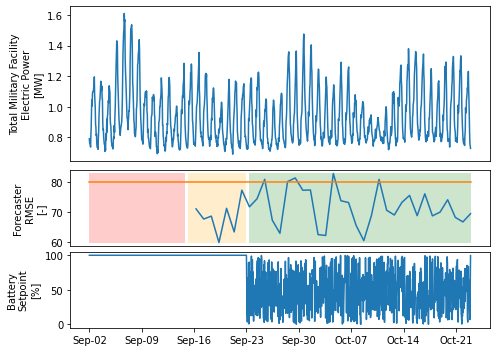

In [8]:
cutoff_date = '2020-10-22'
fig = plt.figure(figsize=(7, 5))
axs = [fig.add_subplot(2, 1, 1), fig.add_subplot(4, 1, 3), fig.add_subplot(4, 1, 4)]

t = data.loc[:cutoff_date]
axs[0].plot(t.index, t['load']/1e3, linestyle='-')
axs[0].set_ylabel('Total Military Facility\nElectric Power\n[MW]')
axs[0].set_xticks([])

t = stats.loc[:cutoff_date]
axs[1].plot(t['date'], t['score_rmse'].mask(t['score_rmse']<0, np.nan))
axs[1].plot(t['date'], [rmse_thr]*len(t))
y = [t['score_rmse'][t['score_rmse']>0].min(), t['score_rmse'].max()]
axs[1].fill_between([t['date'][0],
                     t.index[t['score_rmse']<0].max()-pd.DateOffset(hours=12)],
                    [y[0]]*2, [y[1]]*2, facecolor='red', alpha=0.2, zorder=0)
axs[1].fill_between([t.index[t['score_rmse']<0].max(),
                     t.index[t['cum_rmse']>7].values[0]-pd.DateOffset(hours=12)],
                    [y[0]]*2, [y[1]]*2, facecolor='orange', alpha=0.2, zorder=0)
axs[1].fill_between([t.index[t['cum_rmse']>7].values[0],
                     t['date'][-1]],
                    [y[0]]*2, [y[1]]*2, facecolor='green', alpha=0.2, zorder=0)
axs[1].set_ylabel('Forecaster\nRMSE\n[-]')
axs[1].set_xticks([])
#axs[0].fill_between([-0.5, 4.45], [y]*2, facecolor='lightpink', alpha=0.5, zorder=0)
# for i, r in enumerate(res):
    
#     # RMSE
#     axs[1].plot(i, res[''])

data['batt_ctrl'] = 50 + np.random.uniform(-50, 50, size=len(data))
data.loc[:str(stats.index[stats['cum_rmse']>7].values[0]), 'batt_ctrl'] = 100
t = data.loc[:cutoff_date]
axs[2].plot(t.index, t['batt_ctrl'], linestyle='-')
axs[2].set_ylabel('Battery\nSetpoint\n[%]')
t = stats.loc[:cutoff_date]
xticks = [t.index[i] for i in range(0, len(t), 7)]
axs[2].set_xticks(ticks=xticks)
axs[2].set_xticklabels([d.strftime('%b-%d') for d in xticks])

plt.tight_layout(h_pad=0.1)
plt.show()

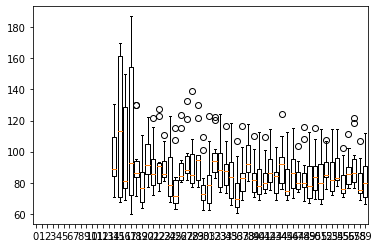

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False)
axs = [axs]

for i, s in enumerate(stats.iterrows()):
    v = pd.Series(json.loads(s[1]['scores_rmse']))
    if v.min() > 0:
        axs[0].boxplot(v.values, positions=[i], widths=0.75)
    else:
        axs[0].boxplot([np.nan], positions=[i])

plt.show()